[Link](https://www.kaggle.com/competitions/digit-recognizer/data) to Competition

I went through this to get a better understanding of the concepts I've learned so far in fastai. Also to brush up on basic numpy, pandas, etc. I used Ahed Jneed's great notebook [here](https://www.kaggle.com/code/ahedjneed/mnist-with-fastai/notebook) as a guidepost whenever I got stuck.

In [1]:
#|default_exp app

In [2]:
#| export
import os
from pathlib import Path
import pandas as pd
import numpy as np
from fastai.vision.all import *
from fastai.vision.all import Image
from torchvision.utils import save_image
from fastai.callback.all import *

matplotlib.rc('image', cmap='Greys')

In [3]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [4]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
#| export
path = Path('digit-recognizer')

In [6]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [7]:
#| export
if iskaggle:
    path = Path('../input/digit-recognizer')
    ! pip install -q dataset

Import Training Set

In [8]:
#| export
train_full = pd.read_csv(path/'train.csv')
test_full = pd.read_csv(path/'test.csv')

In [9]:
#| export
label = train_full.iloc[:, :1]
test_label = test_full.iloc[:, :1]

In [10]:
#| export
image_df = train_full.iloc[:, 1:]
test_image_df = train_full.iloc[:, 1:]

In [11]:
image_df.shape

(42000, 784)

In [12]:
#| export
np_image_array = image_df.values
np_test_array = test_image_df.values

In [13]:
#| export
image_tens = [tensor(x).float() for x in np_image_array]
test_image_tens = [tensor(x).float() for x in np_test_array]

In [14]:
#| export
stacked_img_tens = torch.stack(image_tens).float()/255
stacked_test_tens = torch.stack(test_image_tens).float()/255

In [15]:
#| export
stacked_label_tens = tensor(label).unsqueeze(1)
stacked_test_label_tens = tensor(label).unsqueeze(1)

In [16]:
# img = stacked_img_tens[0].reshape(28, 28)
# save_image(img, './test.png')

In [17]:
#| export
train_path = Path('train')
test_path = Path('test')
def tens_to_img(folder_path, stacked_tensor):
    if not folder_path.exists():
        folder_path.mkdir()
    for i in range(stacked_tensor.shape[0]):
        img = stacked_tensor[i].reshape(28, 28)
        dest = (folder_path/label['label'][i].astype(str))
        dest.mkdir(exist_ok=True)
        img_path = Path(f"{dest}/{i}.png")
        if not img_path.exists():
            save_image(img, img_path)

In [18]:
#| export
tens_to_img(train_path, stacked_img_tens)
tens_to_img(test_path, stacked_test_tens)

In [19]:
# test_path = Path('test')
# if not folder_path.exists():
#     folder_path.mkdir()
# for i in range(stacked_test_tens.shape[0]):
#     img = stacked_test_tens[i].reshape(28, 28)
#     dest = (folder_path/label['label'][i].astype(str))
#     dest.mkdir(exist_ok=True)
#     img_path = Path(f"{dest}/{i}.png")
#     if not img_path.exists():
#         save_image(img, img_path)

In [20]:
#| export
dls = ImageDataLoaders.from_folder(train_path, get_image_files(train_path), bs=255, valid_pct=0.2, seed=42, label_func=parent_label)

In [21]:
#| export
learn = vision_learner(dls, resnet18, loss_func=F.cross_entropy, metrics=accuracy)

/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/petewin/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
#| export
learn.fine_tune(3, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.567315,0.831158,0.740476,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.506698,0.249688,0.922024,00:06
1,0.215462,0.152809,0.952857,00:06
2,0.115310,0.139676,0.956905,00:06


In [23]:
#| export
def find_lr_metrics(learn):
    lr_min, lr_steep, lr_valley = learn.lr_find(suggest_funcs=(minimum, steep, valley))
    lr_min = f"{lr_min:.2e}"
    lr_steep = f"{lr_steep:.2e}"
    lr_valley = f"{lr_valley:.2e}"
    print(f"Minimum: {lr_min}, Steepest Point {lr_steep}, Valley {lr_valley}")
    return lr_min, lr_steep, lr_valley

Minimum: 1.58e-07, Steepest Point 1.32e-06, Valley 1.32e-04


('1.58e-07', '1.32e-06', '1.32e-04')

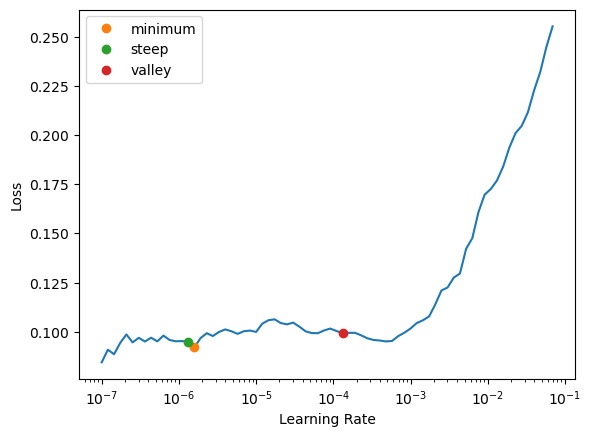

In [24]:
find_lr_metrics(learn)

In [25]:
#| export
learn = vision_learner(dls, resnet18, loss_func=F.cross_entropy, metrics=accuracy).to_fp16()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.092173,0.462286,0.854881,00:06
1,0.421392,0.253255,0.923571,00:06
2,0.277322,0.229340,0.930952,00:06


Minimum: 4.79e-05, Steepest Point 1.10e-06, Valley 9.12e-05


('4.79e-05', '1.10e-06', '9.12e-05')

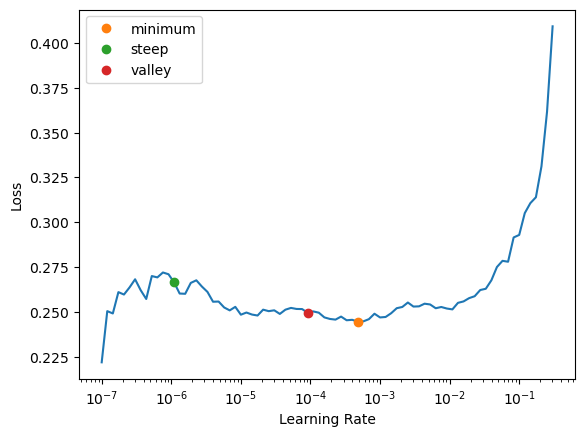

In [26]:
find_lr_metrics(learn)

In [27]:
#| export
learn.unfreeze()

Minimum: 5.25e-04, Steepest Point 2.29e-04, Valley 2.29e-04


('5.25e-04', '2.29e-04', '2.29e-04')

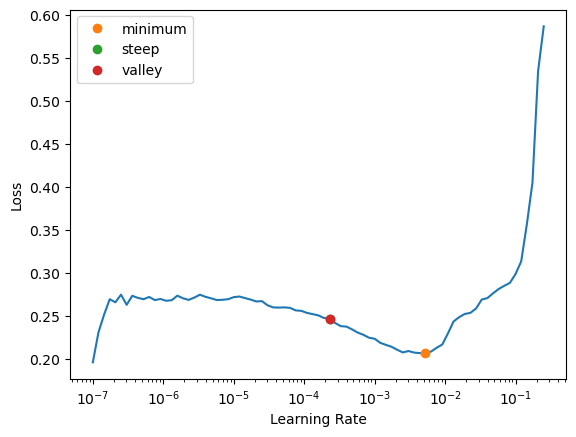

In [28]:
find_lr_metrics(learn)

In [29]:
#| export
learn.fit_one_cycle(5, lr_max=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.139999,0.167694,0.967738,00:07
1,0.099869,0.166788,0.959167,00:07
2,0.048774,0.062008,0.986667,00:07
3,0.028919,0.032981,0.991190,00:07
4,0.012694,0.029259,0.992619,00:07


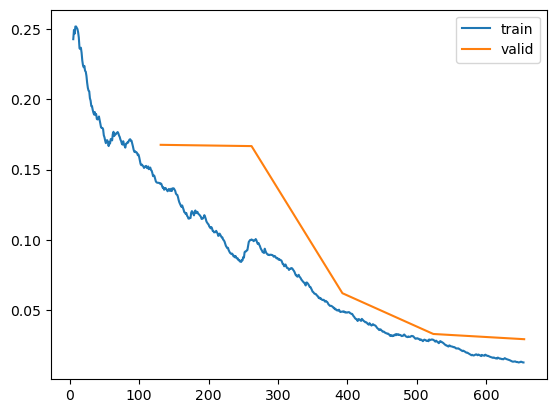

In [30]:
learn.recorder.plot_loss()

In [35]:
#| export
learn.save('model_1')

Path('train/models/model_1.pth')

In [38]:
#| export
path = Path('test')
test_image_files = get_image_files(path)
test_dl = dls.test_dl(test_image_files)

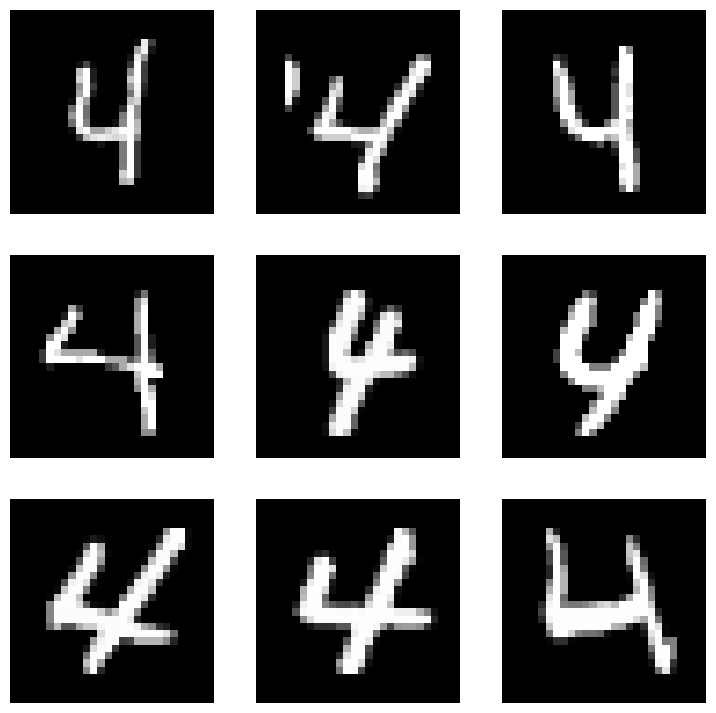

In [41]:
test_dl.show_batch()

In [ ]:
import nbdev
nbdev.export.nb_export('mnist_classifier.ipynb', 'app')
print('Export successful')